In [1]:
# ============================================================ #
# MMAB-NCAS – Imports and Configuration
# ============================================================ #

import numpy as np
import pandas as pd
import json
import math
from pathlib import Path
from typing import List, Tuple
from scipy.optimize import minimize_scalar
from concurrent.futures import ProcessPoolExecutor

# File paths
PARAM_PATH = Path("outputs/grm_item_parameters_mmab_ncas.csv")
RESP_PATH  = Path("outputs/mmbncas_llm_with_theta.csv")

# Company answers (single validation case)
COMP_VEC   = [2,4,5,3,1,4,5,4,4,1,1,5,5,2,1,1,1,2,3,2,5,5]

# Cutoffs and labels
CUTS       = np.array([-0.20, 0.40])
LABELS     = np.array(["novice", "intermediate", "advanced"])


In [2]:
# ============================================================ #
# GRM Utilities
# ============================================================ #

def S(th: float, a: float, b: float) -> float:
    return 1.0 / (1.0 + np.exp(-1.702 * a * (th - b)))

def P(th: float, a: float, bs: np.ndarray, k: int) -> float:
    if k == 1:
        return 1.0 - S(th, a, bs[0])
    if k == 5:
        return S(th, a, bs[3])
    return S(th, a, bs[k-2]) - S(th, a, bs[k-1])

def loglik(th: float, u: np.ndarray, a_vec: np.ndarray, b_mat: np.ndarray) -> float:
    ll = 0.0
    for i, resp in enumerate(u):
        p = max(P(th, a_vec[i], b_mat[i], int(resp)), 1e-12)
        ll += math.log(p)
    return ll

def estimate_theta(u: np.ndarray, a_vec: np.ndarray, b_mat: np.ndarray) -> float:
    return minimize_scalar(lambda t: -loglik(t, u, a_vec, b_mat),
                           bounds=(-4, 4), method="bounded").x

def expected_scores(th: float, a_vec: np.ndarray, b_mat: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    exp, var = [], []
    for i in range(len(a_vec)):
        probs = np.array([P(th, a_vec[i], b_mat[i], k) for k in range(1, 6)])
        mu = np.sum(probs * np.arange(1, 6))
        var_i = np.sum(((np.arange(1, 6) - mu) ** 2) * probs)
        exp.append(mu); var.append(var_i)
    return np.array(exp), np.array(var)


In [3]:
# ============================================================ #
# Single Respondent: Company Case
# ============================================================ #

params  = pd.read_csv(PARAM_PATH)
a_vec   = params["a"].values
b_mat   = params[["b1","b2","b3","b4"]].values

u_arr   = np.array(COMP_VEC)
theta_hat = estimate_theta(u_arr, a_vec, b_mat)

h = 1e-3
info = -(loglik(theta_hat + h, u_arr, a_vec, b_mat) - 2*loglik(theta_hat, u_arr, a_vec, b_mat) + loglik(theta_hat - h, u_arr, a_vec, b_mat)) / h**2
se   = math.sqrt(1.0 / info)

exp_scores, var_items = expected_scores(theta_hat, a_vec, b_mat)
msr    = np.mean((u_arr - exp_scores) ** 2)
outfit = np.mean((u_arr - exp_scores) ** 2 / np.maximum(var_items, 1e-2))
infit  = np.sum((u_arr - exp_scores) ** 2 / np.maximum(var_items, 1e-2)) / len(u_arr)

profile = LABELS[np.digitize(theta_hat, bins=CUTS)]
print(f"Theta_hat = {theta_hat:.3f}  SE = {se:.3f}")
print(f"Profile   = {profile}")
print(f"MSR       = {msr:.3f}   Infit = {infit:.3f}   Outfit = {outfit:.3f}")


Theta_hat = 3.046  SE = 0.103
Profile   = advanced
MSR       = 5.052   Infit = 261.991   Outfit = 261.991


In [4]:
# ============================================================ #
# Profile Estimation – All Synthetic Respondents
# ============================================================ #

df_raw = pd.read_csv(RESP_PATH)
item_cols = [c for c in df_raw.columns if c.lower().startswith("q")]

if len(item_cols) != 22:
    def unpack(o: str) -> List[int]:
        parsed = json.loads(o)
        return [int(parsed[str(k)]) for k in range(1, 23)]
    items = df_raw["output"].apply(unpack).tolist()
    df_items = pd.DataFrame(items, columns=[f"q{k}" for k in range(1, 23)])
    df = pd.concat([df_raw.drop(columns=["output"]), df_items], axis=1)
else:
    df = df_raw.copy()


In [5]:
# ============================================================ #
# Parallel Scoring and Profile Assignment
# ============================================================ #

# Ensure that the values in the DataFrame are integers and handle potential NaN values
u_matrix = df[[f"q{i}" for i in range(1, 23)]].fillna(0).values.astype(int)

def estimate_theta_wrapper(u):
    # Ensure that the input to estimate_theta is a valid array
    if u.size == 0:
        return np.nan  # Return NaN if the input is empty
    return estimate_theta(u, a_vec, b_mat)

with ProcessPoolExecutor() as ex:
    df["theta_hat"] = list(ex.map(estimate_theta_wrapper, u_matrix))

df["profile_hat"] = LABELS[np.digitize(df["theta_hat"], bins=CUTS)]


In [6]:
# ============================================================ #
# Accuracy Metrics + Append Company
# ============================================================ #

if "theta" in df.columns:
    df["theta_imposed"] = df["theta"]
    df["profile_imp"]   = LABELS[np.digitize(df["theta_imposed"], bins=CUTS)]
    rmse = np.sqrt(np.mean((df["theta_hat"] - df["theta_imposed"]) ** 2))
    corr = np.corrcoef(df["theta_hat"], df["theta_imposed"])[0, 1]
    print(f"RMSE(theta_hat, theta_imposed) = {rmse:.3f}")
    print(f"Correlation                   = {corr:.3f}")
    conf = pd.crosstab(df["profile_imp"], df["profile_hat"],
                       rownames=["Imposed"], colnames=["Predicted"])
    print("\nConfusion matrix (imposed vs predicted):")
    print(conf)

company_row = {
    "replica":   -1,
    "profile_imp": "company_actual",
    "theta_imposed": np.nan,
    "theta_hat": theta_hat,
    "profile_hat": profile
}
df = pd.concat([df, pd.DataFrame([company_row])], ignore_index=True)

print(f"\nCompany classified as: {profile}  (theta_hat = {theta_hat:.3f})")


RMSE(theta_hat, theta_imposed) = 0.121
Correlation                   = nan

Confusion matrix (imposed vs predicted):
Predicted     advanced  intermediate  novice
Imposed                                     
advanced           899             3       0
intermediate         0           952      17
novice               0             0    1729

Company classified as: advanced  (theta_hat = 3.046)


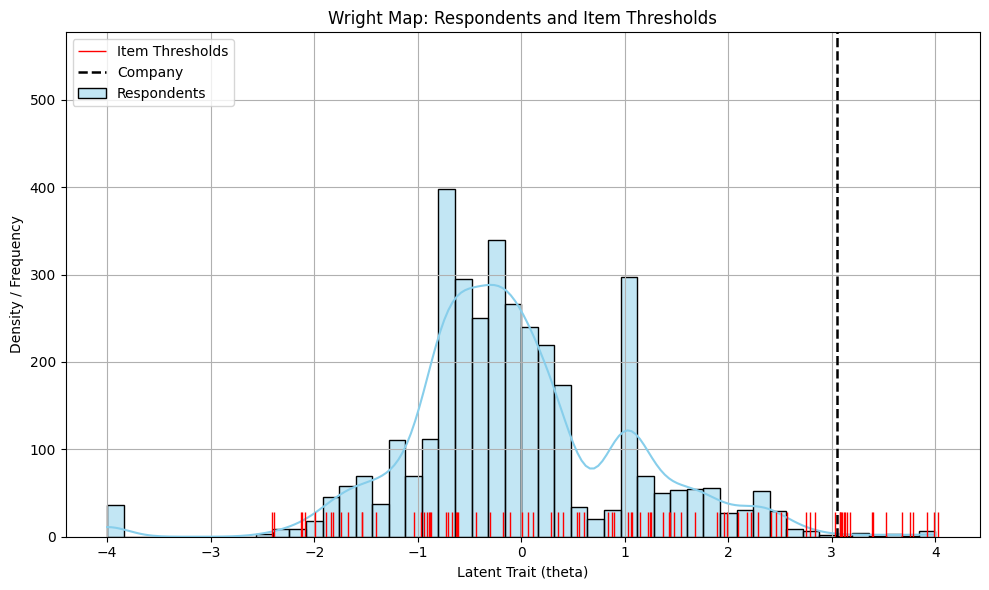

In [19]:
# ============================================================ #
# Wright Map: theta distribution vs item thresholds
# ============================================================ #

import matplotlib.pyplot as plt
import seaborn as sns

# Distribuição dos theta estimados
plt.figure(figsize=(10, 6))
sns.histplot(df["theta_hat"].dropna(), bins=50, kde=True, color="skyblue", label="Respondents")

# Limiares dos itens
for j in range(b_mat.shape[1]):
    sns.rugplot(b_mat[:, j], color="red", height=0.05, label="Item Thresholds" if j == 0 else None)

# Theta da empresa
plt.axvline(theta_hat, color="black", linestyle="--", linewidth=1.8, label="Company")

plt.title("Wright Map: Respondents and Item Thresholds")
plt.xlabel("Latent Trait (theta)")
plt.ylabel("Density / Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Export the figure to the outputs folder with 360 dpi
plt.savefig('outputs/wright_map.png', dpi=360)
plt.show()


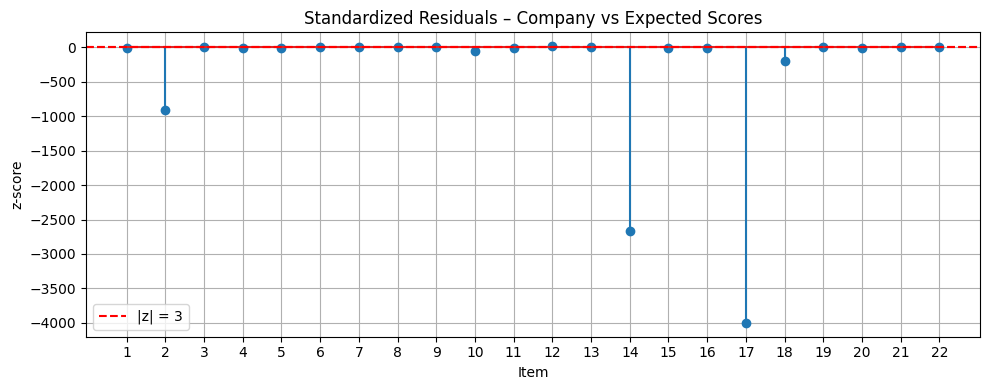

In [20]:
# ============================================================ #
# Standardized residuals per item – Company case
# ============================================================ #

z_scores = (u_arr - exp_scores) / np.sqrt(np.maximum(var_items, 1e-6))

plt.figure(figsize=(10, 4))
plt.stem(range(1, 23), z_scores)  # Removed use_line_collection argument
plt.axhline(3, color="red", linestyle="--", label="|z| = 3")
plt.axhline(-3, color="red", linestyle="--")
plt.title("Standardized Residuals – Company vs Expected Scores")
plt.xlabel("Item")
plt.ylabel("z-score")
plt.xticks(range(1, 23))
plt.grid(True)
plt.legend()
plt.tight_layout()

# Export the figure to the outputs folder with 360 dpi
plt.savefig('outputs/standardized_residuals.png', dpi=360)
plt.show()


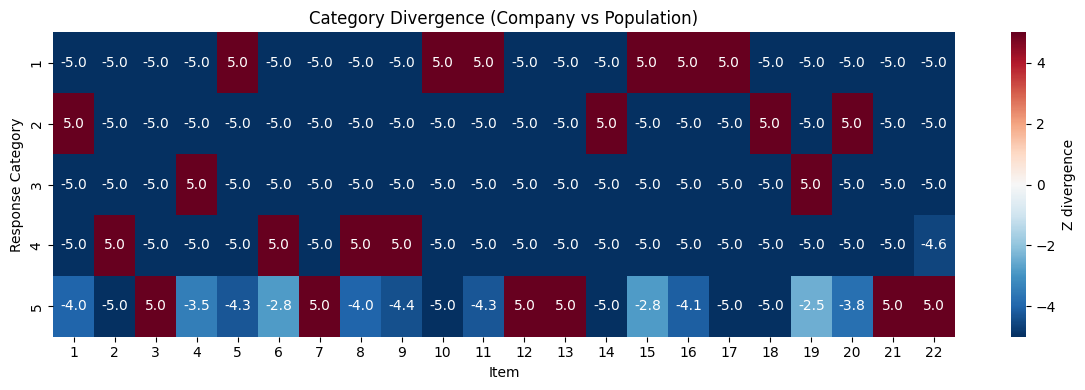

In [21]:
# ============================================================ #
# Categorical divergence per item – Company vs Respondents
# ============================================================ #

from scipy.stats import norm

pop_freq = pd.DataFrame(0, index=range(1, 6), columns=range(1, 23))
for i in range(1, 23):
    counts = df[f"q{i}"].value_counts(normalize=True)
    pop_freq[i] = counts  # Updated to avoid chained assignment warning

comp_cat = pd.Series(u_arr, index=range(1, 23))
comp_onehot = pd.get_dummies(comp_cat).T.reindex(index=range(1, 6), fill_value=0)

# Divergência normalizada
n_pop = df.shape[0]
div = (comp_onehot - pop_freq) / np.sqrt((pop_freq * (1 - pop_freq)) / n_pop)
div = div.clip(-5, 5)

plt.figure(figsize=(12, 4))
sns.heatmap(div, cmap="RdBu_r", center=0, annot=True, fmt=".1f", cbar_kws={"label": "Z divergence"})
plt.title("Category Divergence (Company vs Population)")
plt.xlabel("Item")
plt.ylabel("Response Category")
plt.tight_layout()

# Export the figure to the outputs folder with 360 dpi
plt.savefig('outputs/categorical_divergence.png', dpi=360)
plt.show()


In [13]:
# ============================================================ #
# Posterior Predictive Model Check – Company Fit
# ============================================================ #

def ppmc_simulate(theta_val: float, a_vec, b_mat, n_sim: int = 1000):
    np.random.seed(42)
    sims = []
    for _ in range(n_sim):
        sim_resp = []
        for i in range(len(a_vec)):
            probs = np.array([P(theta_val, a_vec[i], b_mat[i], k) for k in range(1, 6)])
            cat = np.random.choice(np.arange(1, 6), p=probs)
            sim_resp.append(cat)
        sims.append(sim_resp)
    return np.array(sims)

sim_data = ppmc_simulate(theta_hat, a_vec, b_mat, n_sim=1000)

# Estatísticas simuladas
sums = sim_data.sum(axis=1)
maxs = sim_data.max(axis=1)

obs_sum = np.sum(u_arr)
obs_max = np.max(u_arr)

# P-values empíricos
p_sum = np.mean(sums >= obs_sum)
p_max = np.mean(maxs >= obs_max)

print(f"PPMC – p-value (Total Score): {p_sum:.3f}")
print(f"PPMC – p-value (Max Category): {p_max:.3f}")


PPMC – p-value (Total Score): 1.000
PPMC – p-value (Max Category): 1.000


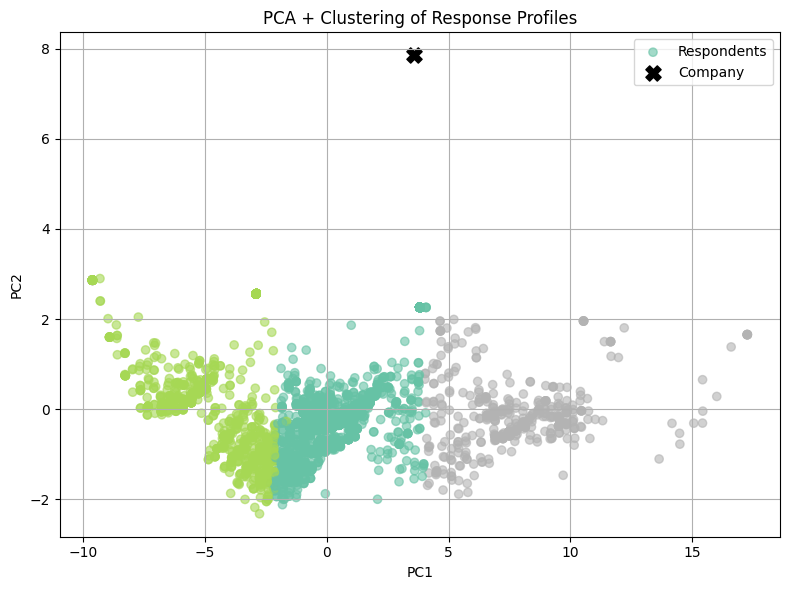

In [22]:
# ============================================================ #
# PCA + Clusterização – Company Similarity Analysis
# ============================================================ #

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Preparar dados
X_resp = df[[f"q{i}" for i in range(1, 23)]].dropna().astype(float).values
X_full = np.vstack([X_resp, u_arr])  # Adiciona empresa como última linha

# Padronização (categorias de 1 a 5, mas normaliza impacto item a item)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# PCA para projeção
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-means clustering (3 grupos como os perfis originais)
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_scaled)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:-1, 0], X_pca[:-1, 1], c=labels[:-1], cmap="Set2", alpha=0.6, label="Respondents")
plt.scatter(X_pca[-1, 0], X_pca[-1, 1], color="black", marker="X", s=120, label="Company")
plt.title("PCA + Clustering of Response Profiles")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Export the figure to the outputs folder with 360 dpi
plt.savefig('outputs/pca_clustering_analysis.png', dpi=360)
plt.show()


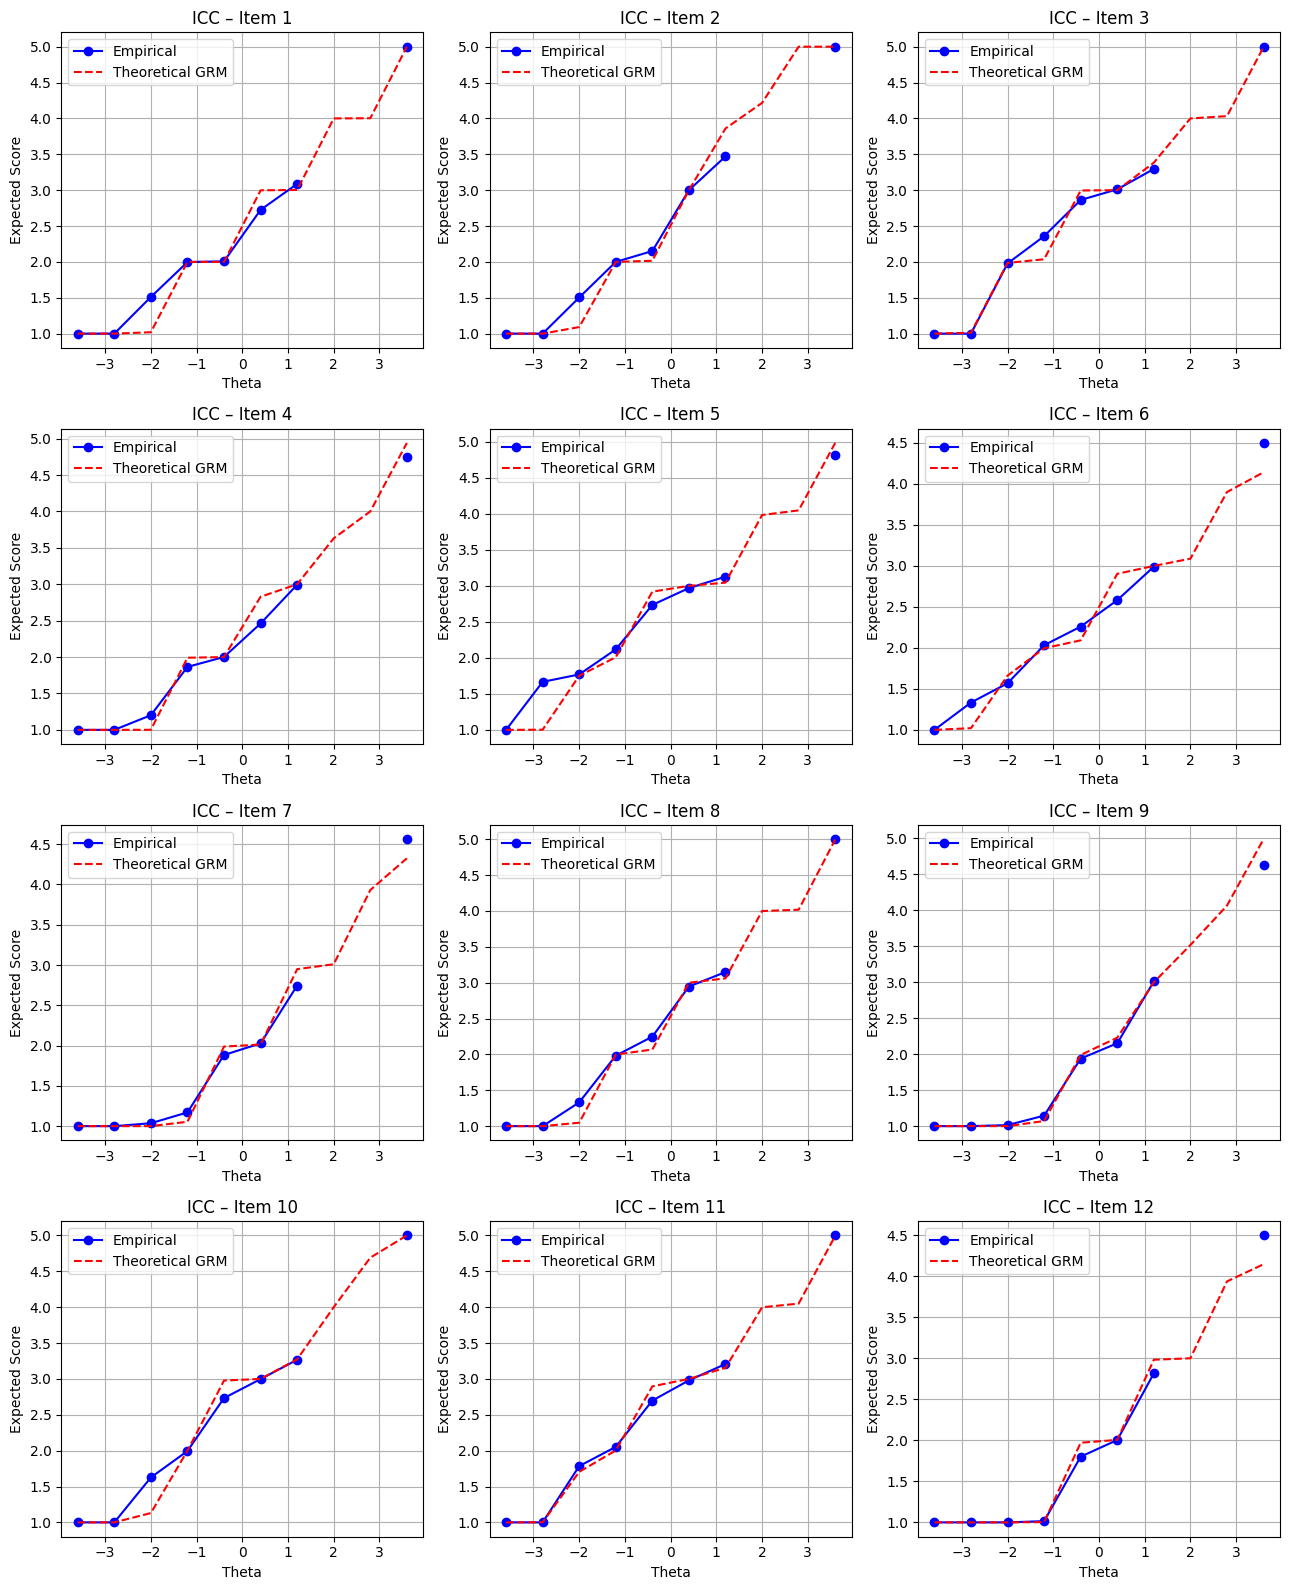

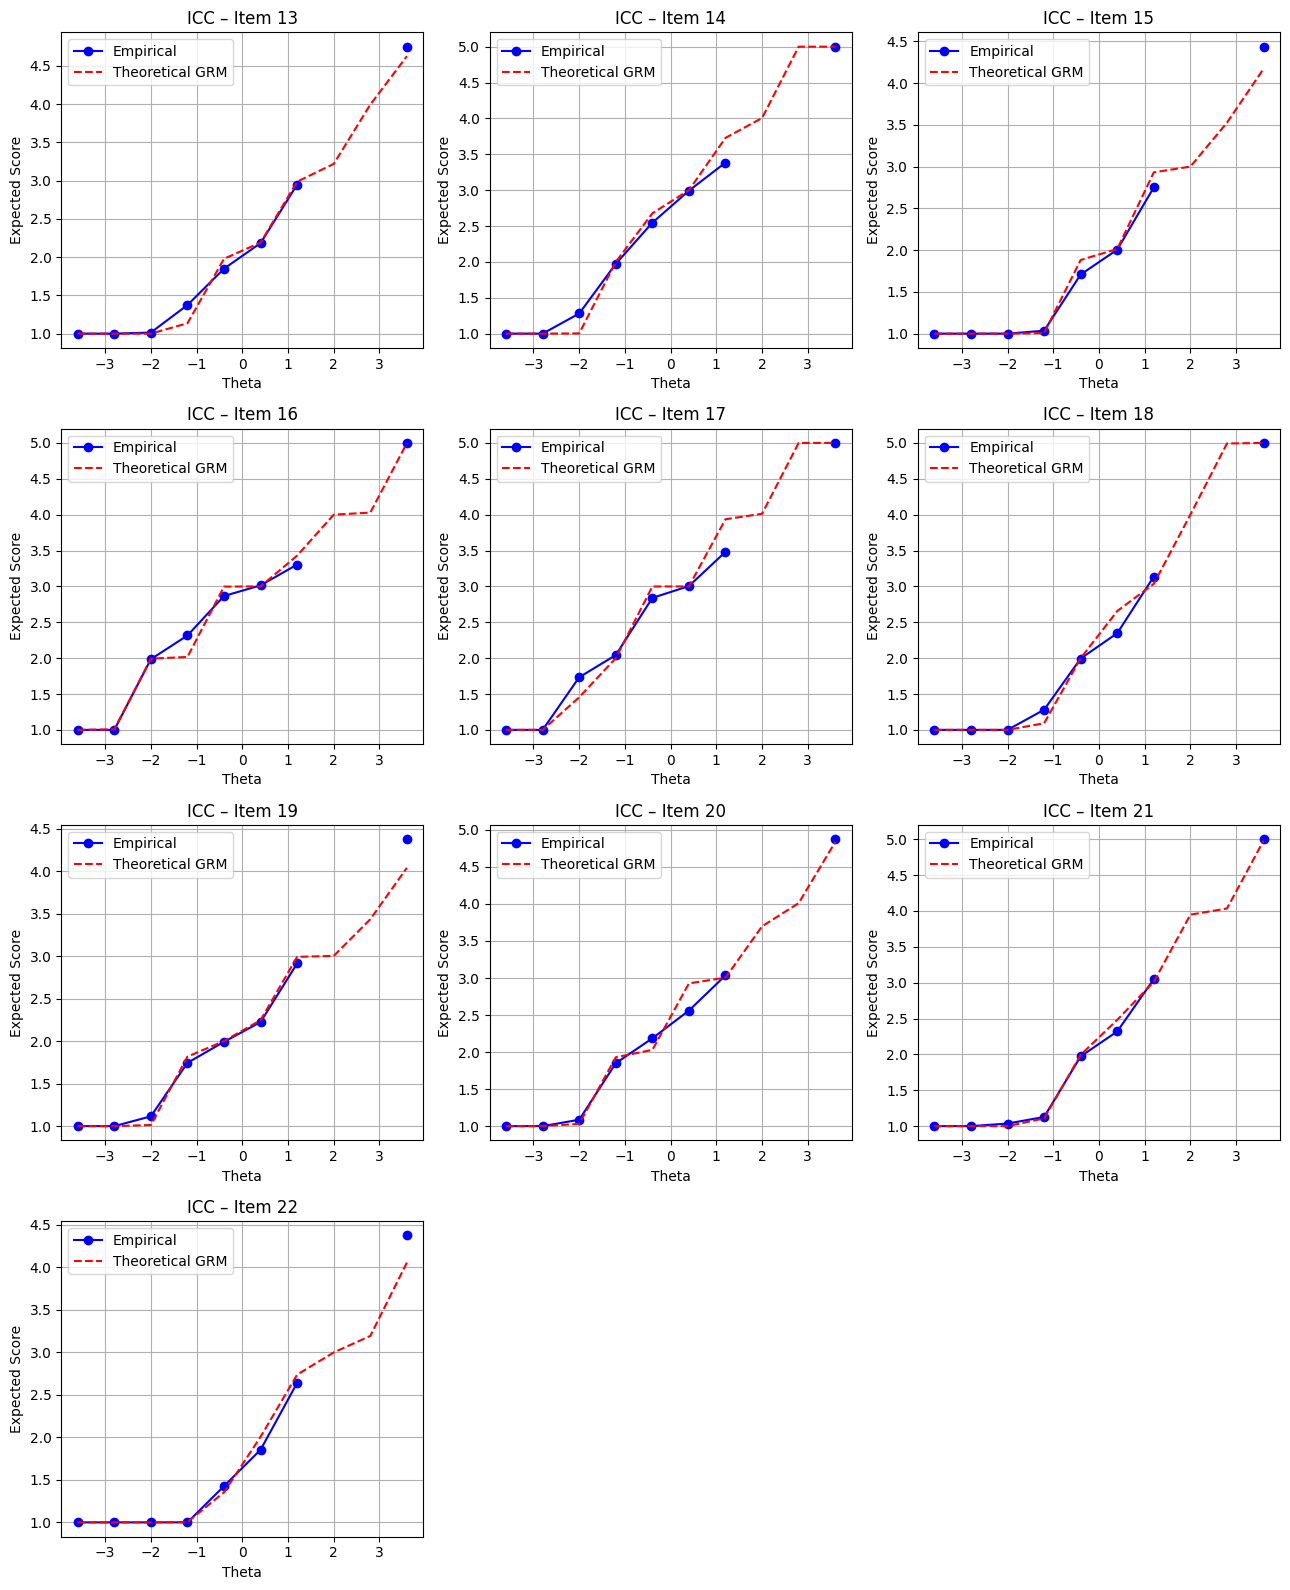

In [28]:
# ============================================================ #
# ICC Plot: Empirical vs Theoretical – All 22 Items
# ============================================================ #

from scipy.stats import binned_statistic
import matplotlib.pyplot as plt

# Considerar todos os 22 itens
all_items = list(range(1, 23))

theta_vals = df["theta_hat"].values
n_bins = 10
bin_edges = np.linspace(-4, 4, n_bins + 1)

# Grid for the first figure (first 12 items)
n_cols = 3
n_rows = 4
fig1, axs1 = plt.subplots(n_rows, n_cols, figsize=(13, 4 * n_rows))
axs1 = axs1.flatten()

for idx, item_id in enumerate(all_items[:12]):
    item_col = f"q{item_id}"
    responses = df[item_col].astype(float).values

    # Empirical mean
    bin_means, _, _ = binned_statistic(theta_vals, responses,
                                       statistic="mean", bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Theoretical GRM curve
    probs = np.array([P(t, a_vec[item_id - 1], b_mat[item_id - 1], k)
                      for t in bin_centers for k in range(1, 6)])
    probs = probs.reshape(len(bin_centers), 5)
    theoretical_mean = np.sum(probs * np.arange(1, 6), axis=1)

    axs1[idx].plot(bin_centers, bin_means, "o-", label="Empirical", color="blue")
    axs1[idx].plot(bin_centers, theoretical_mean, "--", label="Theoretical GRM", color="red")
    axs1[idx].set_title(f"ICC – Item {item_id}")
    axs1[idx].set_xlabel("Theta")
    axs1[idx].set_ylabel("Expected Score")
    axs1[idx].grid(True)
    axs1[idx].legend()
    axs1[idx].set_aspect('auto', adjustable='box')

# Remove eixos extras se existirem
for j in range(len(all_items[:12]), len(axs1)):
    fig1.delaxes(axs1[j])

plt.tight_layout()
plt.savefig("outputs/icc_plot_empirical_vs_theoretical_1.png", dpi=360)
plt.show()

# Grid for the second figure (last 10 items)
fig2, axs2 = plt.subplots(4, 3, figsize=(13, 4 * 4))
axs2 = axs2.flatten()

for idx, item_id in enumerate(all_items[12:]):
    item_col = f"q{item_id}"
    responses = df[item_col].astype(float).values

    # Empirical mean
    bin_means, _, _ = binned_statistic(theta_vals, responses,
                                       statistic="mean", bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Theoretical GRM curve
    probs = np.array([P(t, a_vec[item_id - 1], b_mat[item_id - 1], k)
                      for t in bin_centers for k in range(1, 6)])
    probs = probs.reshape(len(bin_centers), 5)
    theoretical_mean = np.sum(probs * np.arange(1, 6), axis=1)

    axs2[idx].plot(bin_centers, bin_means, "o-", label="Empirical", color="blue")
    axs2[idx].plot(bin_centers, theoretical_mean, "--", label="Theoretical GRM", color="red")
    axs2[idx].set_title(f"ICC – Item {item_id}")
    axs2[idx].set_xlabel("Theta")
    axs2[idx].set_ylabel("Expected Score")
    axs2[idx].grid(True)
    axs2[idx].legend()
    axs2[idx].set_aspect('auto', adjustable='box')

# Remove eixos extras se existirem
for j in range(len(all_items[12:]), len(axs2)):
    fig2.delaxes(axs2[j])

plt.tight_layout()
plt.savefig("outputs/icc_plot_empirical_vs_theoretical_2.png", dpi=360)
plt.show()
